# XGBoost Model Implementation

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import time, os, psutil, atexit                  
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold  # Add this import
from pandas.plotting import parallel_coordinates
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

## Step1: Load Time Cost

In [2]:
process      = psutil.Process(os.getpid())       
_t0          = time.perf_counter()               
_mem0        = process.memory_info().rss         

def _report():
    dt   = time.perf_counter() - _t0            
    mem1 = process.memory_info().rss            
    print(f"\n[STATS] runtime = {dt:,.2f} s")
    print(f"[STATS] memory  = {_mem0/2**20:,.2f} → {mem1/2**20:,.2f} MB "
          f"(Δ {(mem1-_mem0)/2**20:,.2f} MB)")

atexit.register(_report) 

<function __main__._report()>

## Step2: Load npz Data File

In [3]:
data = np.load('image_data.npz')
images_loaded = data['images']
labels_loaded = data['labels']

df = pd.DataFrame({
    'normalized_image_data': list(images_loaded),
    'label': list(labels_loaded)
})

print(f'df.shape: {df.shape}')
    
df_cleaned = df.dropna(subset=['normalized_image_data', 'label'])
print(f'df_cleaned.shape: {df_cleaned.shape}')

# Get cleaned arrays
images_cleaned = np.array(df_cleaned['normalized_image_data'].tolist())
labels_cleaned = np.array(df_cleaned['label'].tolist())

df.shape: (1012, 2)
df_cleaned.shape: (1012, 2)


## Step3: Define Features Extraction Functions
<mark>The most time cost takes<mark>

- intensity features (fast)
- glcm features (slow)
- grad features (slow)

In [4]:
from tqdm import tqdm
import numpy as np

def intensity_features(img):
    # Replace NaN values with 0 (or another appropriate value)
    img = np.nan_to_num(img)
    flat = img.flatten()
    mean = np.mean(flat)
    std = np.std(flat)
    skew = np.mean((flat - mean)**3) / (std**3 + 1e-10)
    kurt = np.mean((flat - mean)**4) / (std**4 + 1e-10) - 3
    q25, q50, q75 = np.percentile(flat, [25, 50, 75])
    hist = np.histogram(flat, bins=32, range=(flat.min(), flat.max()))[0]
    entropy = -np.sum(hist * np.log2(hist + 1e-10))
    return [mean, std, skew, kurt, q25, q50, q75, entropy]

def glcm_features(img):
    img = np.nan_to_num(img)
    # Scale image to 0-255 range for GLCM
    img = (img - img.min()) / (img.max() - img.min() + 1e-10) * 255
    img = img.astype(int)
    
    glcm = np.zeros((256, 256), dtype=int)
    for i in range(img.shape[0]-1):
        for j in range(img.shape[1]-1):
            x, y = img[i,j], img[i,j+1]
            glcm[x, y] += 1
    glcm = glcm / (np.sum(glcm) + 1e-10)
    
    contrast = np.sum(glcm * (np.arange(256)[:,None] - np.arange(256))**2)
    energy = np.sum(glcm**2)
    homogeneity = np.sum(glcm / (1 + (np.arange(256)[:,None] - np.arange(256))**2))
    return [contrast, energy, homogeneity]

def gradient_features(img):
    img = np.nan_to_num(img)
    kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    kernel_y = kernel_x.T
    grad_x = np.zeros_like(img)
    grad_y = np.zeros_like(img)
    
    for i in range(1, img.shape[0]-1):
        for j in range(1, img.shape[1]-1):
            grad_x[i,j] = np.sum(img[i-1:i+2, j-1:j+2] * kernel_x)
            grad_y[i,j] = np.sum(img[i-1:i+2, j-1:j+2] * kernel_y)
    
    grad_mag = np.sqrt(grad_x**2 + grad_y**2)
    return [np.mean(grad_mag), np.std(grad_mag)]

X_intensity = []
X_glcm = []
X_gradient = []
y = df_cleaned['label'].values.astype(np.float32)

In [5]:
# # Extract features from cleaned images
# X = np.array([intensity_features(img) + glcm_features(img) + gradient_features(img) for img in images_cleaned])
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# 特征提取函数
def intensity_features(img):
    img = np.nan_to_num(img)
    flat = img.flatten()
    mean = np.mean(flat)
    std = np.std(flat)
    skew = np.mean((flat - mean)**3) / (std**3 + 1e-10)
    kurt = np.mean((flat - mean)**4) / (std**4 + 1e-10) - 3
    q25, q50, q75 = np.percentile(flat, [25, 50, 75])
    hist = np.histogram(flat, bins=32, range=(flat.min(), flat.max()))[0]
    entropy = -np.sum(hist * np.log2(hist + 1e-10))
    return [mean, std, skew, kurt, q25, q50, q75, entropy]

def glcm_features(img):
    img = np.nan_to_num(img)
    img = (img - img.min()) / (img.max() - img.min() + 1e-10) * 255
    img = img.astype(int)
    
    glcm = np.zeros((256, 256), dtype=int)
    for i in range(img.shape[0]-1):
        for j in range(img.shape[1]-1):
            x, y = img[i,j], img[i,j+1]
            glcm[x, y] += 1
    glcm = glcm / (np.sum(glcm) + 1e-10)
    
    contrast = np.sum(glcm * (np.arange(256)[:,None] - np.arange(256))**2)
    energy = np.sum(glcm**2)
    homogeneity = np.sum(glcm / (1 + (np.arange(256)[:,None] - np.arange(256))**2))
    return [contrast, energy, homogeneity]

def gradient_features(img):
    img = np.nan_to_num(img)
    kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    kernel_y = kernel_x.T
    grad_x = np.zeros_like(img)
    grad_y = np.zeros_like(img)
    
    for i in range(1, img.shape[0]-1):
        for j in range(1, img.shape[1]-1):
            grad_x[i,j] = np.sum(img[i-1:i+2, j-1:j+2] * kernel_x)
            grad_y[i,j] = np.sum(img[i-1:i+2, j-1:j+2] * kernel_y)
    
    grad_mag = np.sqrt(grad_x**2 + grad_y**2)
    return [np.mean(grad_mag), np.std(grad_mag)]

## Step4: Conduct Features Extraction & Visualzation

Extracting Features:  25%|████████▊                           | 249/1012 [01:29<04:19,  2.94image/s]

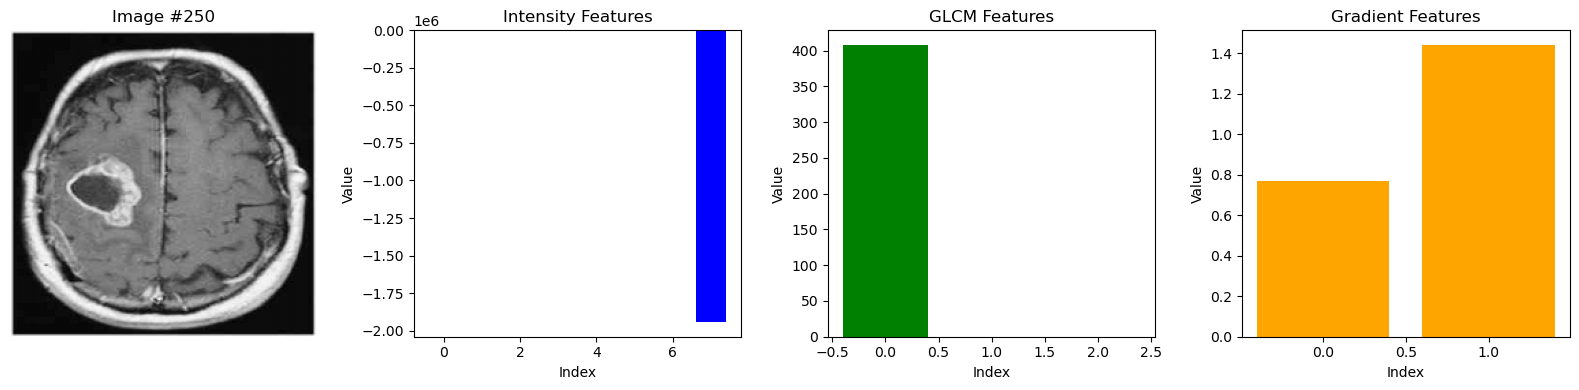

Extracting Features:  49%|█████████████████▊                  | 499/1012 [02:58<02:56,  2.90image/s]

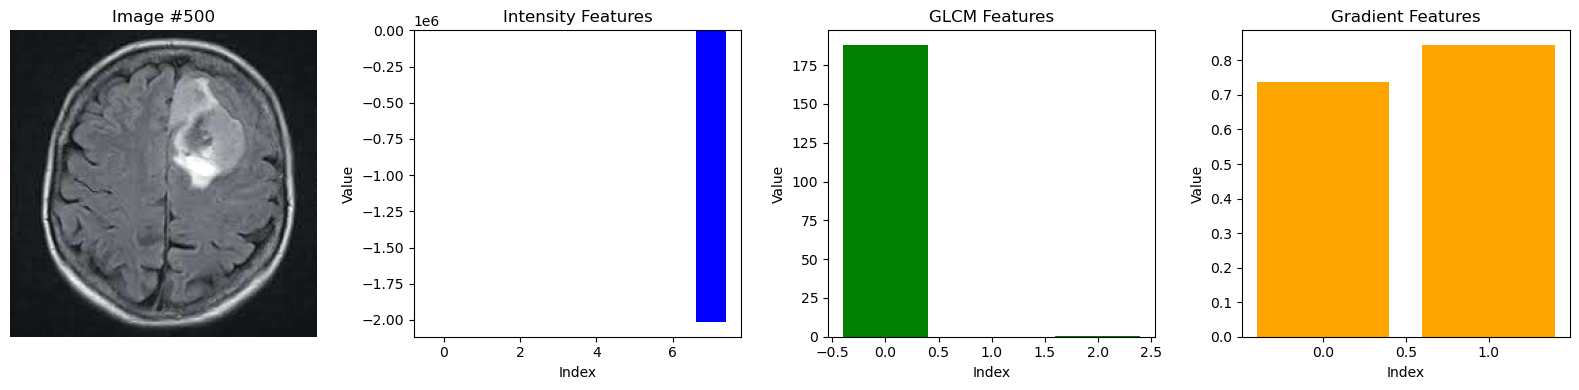

Extracting Features:  74%|██████████████████████████▋         | 749/1012 [04:36<01:30,  2.92image/s]

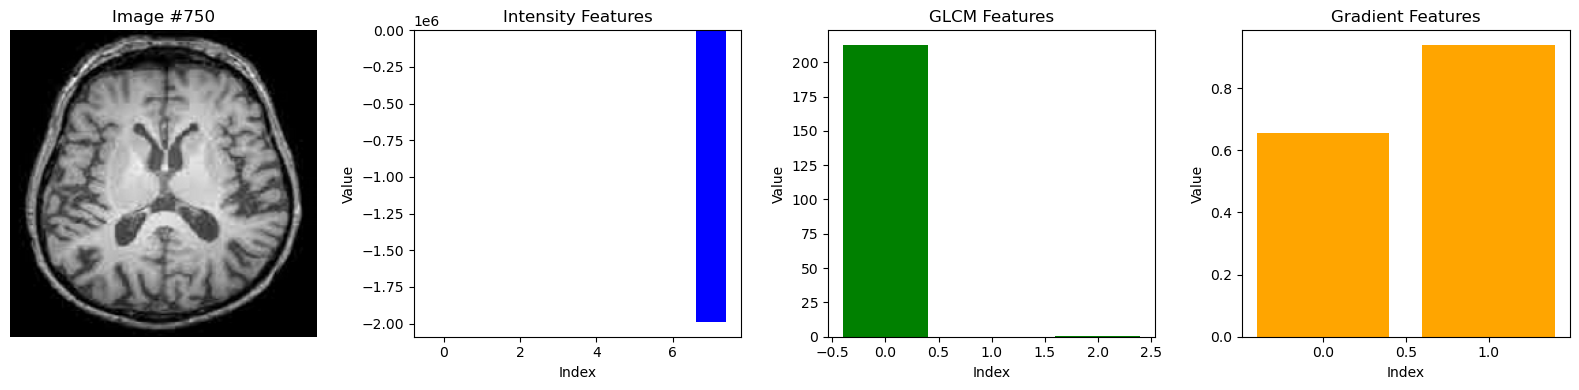

Extracting Features:  99%|███████████████████████████████████▌| 999/1012 [06:08<00:04,  2.82image/s]

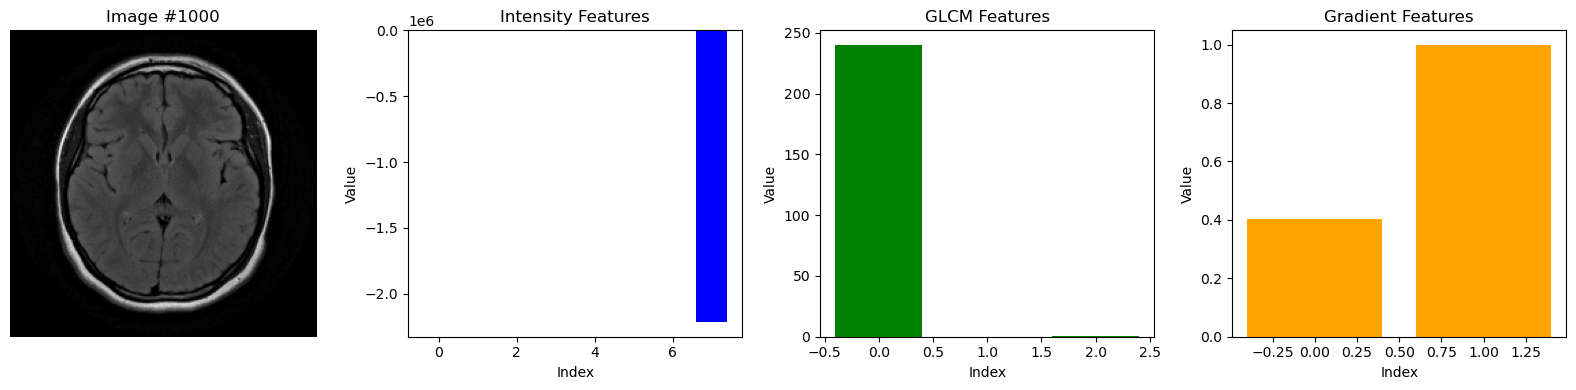

Extracting Features: 100%|███████████████████████████████████| 1012/1012 [06:13<00:00,  2.71image/s]


In [6]:
# print out the progress of the image features
features = []
for idx, img in enumerate(tqdm(images_cleaned, desc="Extracting Features", unit="image", ncols=100)):
    intensity_f = intensity_features(img)
    glcm_f = glcm_features(img)
    gradient_f = gradient_features(img)
    
    # f = intensity_features(img) + glcm_features(img) + gradient_features(img)
    f = intensity_f + glcm_f + gradient_f
    features.append(f)

    # each 100 images print out one result report 
    # if (idx + 1) % 100 == 0:
    #     print(f"✅ Processed {idx + 1}/{len(images_cleaned)} images...", flush=True)
    if (idx + 1) % 250 == 0:
        plt.figure(figsize=(16, 4))
        
        plt.subplot(1, 4, 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Image #{idx+1}")
        plt.axis('off')

        # Intensity features
        plt.subplot(1, 4, 2)
        plt.bar(range(len(intensity_f)), intensity_f, color='blue')
        plt.title("Intensity Features")
        plt.xlabel("Index")
        plt.ylabel("Value")

        # GLCM features
        plt.subplot(1, 4, 3)
        plt.bar(range(len(glcm_f)), glcm_f, color='green')
        plt.title("GLCM Features")
        plt.xlabel("Index")
        plt.ylabel("Value")

        # Gradient featuers
        plt.subplot(1, 4, 4)
        plt.bar(range(len(gradient_f)), gradient_f, color='orange')
        plt.title("Gradient Features")
        plt.xlabel("Index")
        plt.ylabel("Value")

        plt.tight_layout()
        plt.show()

# transform into Numpy
X = np.array(features)
y = labels_cleaned.astype(int)

# making feature normalizar
def featureNormalize(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    X_norm = (X - mu) / sigma
    return X_norm, mu, sigma

X_norm, mu, sigma = featureNormalize(X)
X = np.hstack((np.ones((X_norm.shape[0], 1)), X_norm))

## Step5: Define Tree


It builds a strong classifier by improving the performance of **weak classifiers (usually decision trees)**. XGBoost adds **optimization techniques such as regularization (to avoid overfitting) and column sampling (to avoid high variance)** to the traditional gradient boosting method, which improves efficiency and accuracy.

In [7]:
# XGBoost implementation
class DecisionNode:
    def __init__(self, feature_idx=None, threshold=None, left=None, right=None, value=None):
        self.feature_idx = feature_idx
        self.threshold = threshold # used as Splitting thres
        self.left = left # left sub-tree
        self.right = right # right sub-tree
        self.value = value # Leaf node, value stores the value of the node (i.e. predicted value)
        
    def is_leaf(self):
        return self.value is not None

# tree class
class XGBoostTree:
    def __init__(self, max_depth=3, min_samples_split=2, gamma=0, lambda_=1, learning_rate=0.1):
        self.max_depth = max_depth # tree max depth
        self.min_samples_split = min_samples_split # min demand for tree sample split (samller)
        # smaller than this min_sample split demand wont split the node 
        self.gamma = gamma # reg min need
        self.lambda_ = lambda_ # L2 reg
        self.learning_rate = learning_rate # LR
        self.root = None # init 
        
    def _calculate_gain(self, g, h, g_l, h_l, g_r, h_r):
        gain = 0.5 * ((g_l**2 / (h_l + self.lambda_)) + (g_r**2 / (h_r + self.lambda_)) - (g**2 / (h + self.lambda_))) - self.gamma
        return gain
        
    def _find_best_split(self, X, g, h):
        best_gain = -np.inf
        best_feature_idx, best_threshold = None, None
        
        # run through all the feature selections (ALL)
        for feature_idx in range(X.shape[1]):
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                left_mask = X[:, feature_idx] <= threshold
                right_mask = ~left_mask
                
                if np.sum(left_mask) < self.min_samples_split or np.sum(right_mask) < self.min_samples_split:
                    continue
                    
                g_l = np.sum(g[left_mask])
                h_l = np.sum(h[left_mask])
                g_r = np.sum(g[right_mask])
                h_r = np.sum(h[right_mask])
                
                gain = self._calculate_gain(np.sum(g), np.sum(h), g_l, h_l, g_r, h_r)
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature_idx = feature_idx
                    best_threshold = threshold
                    
        return best_feature_idx, best_threshold, best_gain
        
    # using to develop the tree (training core)
    def _build_tree(self, X, g, h, depth=0):
        if depth >= self.max_depth or len(X) < self.min_samples_split:
            leaf_value = -np.sum(g) / (np.sum(h) + self.lambda_)
            return DecisionNode(value=leaf_value)
            
        feature_idx, threshold, gain = self._find_best_split(X, g, h)
        
        if gain <= 0:  # No positive gain
            leaf_value = -np.sum(g) / (np.sum(h) + self.lambda_)
            return DecisionNode(value=leaf_value)
            
        left_mask = X[:, feature_idx] <= threshold
        right_mask = ~left_mask
        
        left = self._build_tree(X[left_mask], g[left_mask], h[left_mask], depth + 1)
        right = self._build_tree(X[right_mask], g[right_mask], h[right_mask], depth + 1)
        
        return DecisionNode(feature_idx, threshold, left, right)
        
    def fit(self, X, g, h):
        self.root = self._build_tree(X, g, h)
        
    def predict(self, X):
        return np.array([self._predict_tree(x, self.root) for x in X])
        
    def _predict_tree(self, x, node):
        if node.is_leaf():
            return node.value * self.learning_rate
            
        if x[node.feature_idx] <= node.threshold:
            return self._predict_tree(x, node.left)
        else:
            return self._predict_tree(x, node.right)


## Step6: XGBoost Classifier

<img src="md_image_material/xgboost.png" width="500" height="350" style="float: left; margin-right: 10px;">
<img src="md_image_material/xgboost1.png" width="500" height="350" style="float: left; margin-right: 10px;">


In [8]:
from tqdm import tqdm
import numpy as np

class XGBoostClassifier:
    def __init__(self, n_estimators=100, max_depth=3, min_samples_split=2, gamma=0, lambda_=1, learning_rate=0.1):
        self.n_estimators = n_estimators # the number of decision trees in the XGBoost
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split # limit the min demand
        self.gamma = gamma # gain diff > gamma will take splits
        self.lambda_ = lambda_ # L2 Reg Constant limit 
        self.learning_rate = learning_rate
        self.trees = [] # to store the tree in each training epochs
        self.base_pred = None
        
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
        
    def _logistic_loss_gradient(self, y, pred):
        return pred - y
        
    def _logistic_loss_hessian(self, pred):
        return pred * (1 - pred)
        
    def fit(self, X, y):
        # Initialize base prediction 
        self.base_pred = np.log(np.sum(y) / np.sum(1 - y))
        pred = np.full_like(y, self.base_pred, dtype=float)
        
        # Use tqdm to show progress for n_estimators
        for _ in tqdm(range(self.n_estimators), desc="Fitting XGBoost Model", unit="tree"):
            # Calculate gradients and hessians
            # using sigmoid functions to make pred value into the prob
            pred_proba = self._sigmoid(pred)
            
            # used to train the model fitting (X_features, g, h)
            g = self._logistic_loss_gradient(y, pred_proba)
            h = self._logistic_loss_hessian(pred_proba)
            
            # Fit a tree to the gradients
            tree = XGBoostTree(max_depth=self.max_depth, 
                            min_samples_split=self.min_samples_split,
                            gamma=self.gamma,
                            lambda_=self.lambda_,
                            learning_rate=self.learning_rate)
            
            # using the tree class method to train
            # in fact, it's building the tree
            tree.fit(X, g, h)
            
            # Update predictions
            pred += tree.predict(X)
            self.trees.append(tree)
            
    def predict_proba(self, X):
        pred = np.full(X.shape[0], self.base_pred, dtype=float)
        for tree in self.trees:
            pred += tree.predict(X)
        return self._sigmoid(pred)
        
    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)


## Step7: Train XGBoost Model

In [9]:
# Train XGBoost model
print("\nTraining XGBoost model...")

# using the sklearn package to split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

xgb = XGBoostClassifier(n_estimators=100, max_depth=3, learning_rate=0.1)
xgb.fit(X_train, y_train)


Training XGBoost model...


Fitting XGBoost Model: 100%|██████████| 100/100 [00:37<00:00,  2.66tree/s]


## Step8: Evaluate Performance & Threshold Analysis (optimal threshold)

In [10]:
# Evaluation functions
def evaluate_performance(y_true, y_pred):
    print("\nDetailed Evaluation:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred, zero_division=0):.4f}")

    unique, counts = np.unique(y_pred, return_counts=True)
    print(f"Prediction distribution: {dict(zip(unique, counts/len(y_pred)))}")
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

# Evaluate on training set
print("\nTraining Set Performance:")
y_train_pred = xgb.predict(X_train)
evaluate_performance(y_train, y_train_pred)

# Evaluate on test set
print("\nTest Set Performance:")
y_test_pred = xgb.predict(X_test)
evaluate_performance(y_test, y_test_pred)

# Threshold analysis
print("\nThreshold Analysis:")
thresholds = np.linspace(0.1, 0.9, 9)
best_threshold = 0.5
best_f1 = 0

for threshold in thresholds:
    y_test_adjusted = xgb.predict(X_test, threshold=threshold)
    current_f1 = f1_score(y_test, y_test_adjusted)
    print(f"Threshold {threshold:.1f}: F1 = {current_f1:.4f}, "
        f"Precision = {precision_score(y_test, y_test_adjusted, zero_division=0):.4f}, "
        f"Recall = {recall_score(y_test, y_test_adjusted, zero_division=0):.4f}")
    if current_f1 > best_f1:
        best_f1 = current_f1
        best_threshold = threshold

print(f"\nSuggested optimal threshold: {best_threshold:.2f}")

#​Medical diagnosis requires minimizing both false positives (misdiagnosis) and false negatives (missed diagnosis)


Training Set Performance:

Detailed Evaluation:
Accuracy: 0.9915
Precision: 0.9931
Recall: 0.9931
F1 Score: 0.9931
Prediction distribution: {0: 0.3870056497175141, 1: 0.6129943502824858}

Confusion Matrix:
[[271   3]
 [  3 431]]

Test Set Performance:

Detailed Evaluation:
Accuracy: 0.9342
Precision: 0.9415
Recall: 0.9516
F1 Score: 0.9465
Prediction distribution: {0: 0.3815789473684211, 1: 0.618421052631579}

Confusion Matrix:
[[107  11]
 [  9 177]]

Threshold Analysis:
Threshold 0.1: F1 = 0.8836, Precision = 0.7915, Recall = 1.0000
Threshold 0.2: F1 = 0.9113, Precision = 0.8409, Recall = 0.9946
Threshold 0.3: F1 = 0.9141, Precision = 0.8619, Recall = 0.9731
Threshold 0.4: F1 = 0.9323, Precision = 0.9040, Recall = 0.9624
Threshold 0.5: F1 = 0.9465, Precision = 0.9415, Recall = 0.9516
Threshold 0.6: F1 = 0.9508, Precision = 0.9667, Recall = 0.9355
Threshold 0.7: F1 = 0.9359, Precision = 0.9711, Recall = 0.9032
Threshold 0.8: F1 = 0.8986, Precision = 0.9748, Recall = 0.8333
Threshold 0.

In [11]:
# Retrain the model with the best threshold found
print(f"\nRetraining and evaluating with optimal threshold {best_threshold:.2f}...")

# Evaluate with best threshold on training set
print("\nTraining Set Performance with Best Threshold:")
y_train_pred_best = xgb.predict(X_train, threshold=best_threshold)
evaluate_performance(y_train, y_train_pred_best)

# Evaluate with best threshold on test set
print("\nTest Set Performance with Best Threshold:")
y_test_pred_best = xgb.predict(X_test, threshold=best_threshold)
evaluate_performance(y_test, y_test_pred_best)

# Compare with default threshold (0.5) for reference
print("\nComparison with Default Threshold (0.5):")
print("\nTraining Set Performance with Threshold=0.5:")
y_train_pred_default = xgb.predict(X_train, threshold=0.5)
evaluate_performance(y_train, y_train_pred_default)

print("\nTest Set Performance with Threshold=0.5:")
y_test_pred_default = xgb.predict(X_test, threshold=0.5)
evaluate_performance(y_test, y_test_pred_default)

# Print improvement summary
def print_improvement(metric, best, default):
    improvement = (best - default) / default * 100
    direction = "increased" if improvement >= 0 else "decreased"
    print(f"{metric}: {default:.4f} → {best:.4f} ({direction} by {abs(improvement):.1f}%)")

print("\nPerformance Improvement Summary:")
print("Training Set:")
print_improvement("F1 Score", 
                f1_score(y_train, y_train_pred_best, zero_division=0),
                f1_score(y_train, y_train_pred_default, zero_division=0))

print("\nTest Set:")
print_improvement("F1 Score", 
                f1_score(y_test, y_test_pred_best, zero_division=0),
                f1_score(y_test, y_test_pred_default, zero_division=0))


Retraining and evaluating with optimal threshold 0.60...

Training Set Performance with Best Threshold:

Detailed Evaluation:
Accuracy: 0.9915
Precision: 0.9977
Recall: 0.9885
F1 Score: 0.9931
Prediction distribution: {0: 0.3926553672316384, 1: 0.6073446327683616}

Confusion Matrix:
[[273   1]
 [  5 429]]

Test Set Performance with Best Threshold:

Detailed Evaluation:
Accuracy: 0.9408
Precision: 0.9667
Recall: 0.9355
F1 Score: 0.9508
Prediction distribution: {0: 0.40789473684210525, 1: 0.5921052631578947}

Confusion Matrix:
[[112   6]
 [ 12 174]]

Comparison with Default Threshold (0.5):

Training Set Performance with Threshold=0.5:

Detailed Evaluation:
Accuracy: 0.9915
Precision: 0.9931
Recall: 0.9931
F1 Score: 0.9931
Prediction distribution: {0: 0.3870056497175141, 1: 0.6129943502824858}

Confusion Matrix:
[[271   3]
 [  3 431]]

Test Set Performance with Threshold=0.5:

Detailed Evaluation:
Accuracy: 0.9342
Precision: 0.9415
Recall: 0.9516
F1 Score: 0.9465
Prediction distribution

```

Retraining and evaluating with optimal threshold 0.60...

Training Set Performance with Best Threshold:

Detailed Evaluation:
Accuracy: 0.9915
Precision: 0.9977
Recall: 0.9885
F1 Score: 0.9931
Prediction distribution: {0: 0.3926553672316384, 1: 0.6073446327683616}

Confusion Matrix:
[[273   1]
 [  5 429]]

Test Set Performance with Best Threshold:

Detailed Evaluation:
Accuracy: 0.9408
Precision: 0.9667
Recall: 0.9355
F1 Score: 0.9508
Prediction distribution: {0: 0.40789473684210525, 1: 0.5921052631578947}

Confusion Matrix:
[[112   6]
 [ 12 174]]


---------------------------------------------------------------------------


Comparison with Default Threshold (0.5):

Training Set Performance with Threshold=0.5:

Detailed Evaluation:
Accuracy: 0.9915
Precision: 0.9931
Recall: 0.9931
F1 Score: 0.9931
Prediction distribution: {0: 0.3870056497175141, 1: 0.6129943502824858}

Confusion Matrix:
[[271   3]
 [  3 431]]


Test Set Performance with Threshold=0.5:

Detailed Evaluation:
Accuracy: 0.9342
Precision: 0.9415
Recall: 0.9516
F1 Score: 0.9465
Prediction distribution: {0: 0.3815789473684211, 1: 0.618421052631579}

Confusion Matrix:
[[107  11]
 [  9 177]]


---------------------------------------------------------------------------


Performance Improvement Summary:
Training Set:
F1 Score: 0.9931 → 0.9931 (decreased by 0.0%)

Test Set:
F1 Score: 0.9465 → 0.9508 (increased by 0.5%)

```

In [12]:
# from sklearn.model_selection import KFold  # Add this import
# from pandas.plotting import parallel_coordinates

## Step9: Cross-Validation (k=5)

In [13]:
from sklearn.model_selection import KFold  # Add this import

# Cross-validation
def cross_validate_xgb(X, y, k=5, n_estimators=100, max_depth=3, learning_rate=0.1):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_metrics = []
    
    for train_idx, val_idx in kf.split(X):
        # Split data
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Train model
        model = XGBoostClassifier(n_estimators=n_estimators, 
                            max_depth=max_depth, 
                            learning_rate=learning_rate)
        model.fit(X_train, y_train)
        
        # Evaluate on validation set
        y_pred = model.predict(X_val)
        fold_metrics.append({
            'accuracy': accuracy_score(y_val, y_pred),
            'precision': precision_score(y_val, y_pred, zero_division=0),
            'recall': recall_score(y_val, y_pred, zero_division=0),
            'f1': f1_score(y_val, y_pred, zero_division=0)
        })
    
    # Calculate average metrics
    avg_metrics = {metric: np.mean([m[metric] for m in fold_metrics]) 
                for metric in fold_metrics[0].keys()}
    
    return avg_metrics, fold_metrics

# Run cross-validation
cv_metrics, fold_metrics = cross_validate_xgb(X, y)
print("\nCross-Validation Results:")

for metric, value in cv_metrics.items():
    print(f"Average {metric}: {value:.4f}")

Fitting XGBoost Model: 100%|██████████| 100/100 [00:44<00:00,  2.27tree/s]


Cross-Validation Results:
Average accuracy: 0.9426
Average precision: 0.9451
Average recall: 0.9594
Average f1: 0.9518


Fitting XGBoost Model: 100%|██████████| 100/100 [00:48<00:00,  2.05tree/s]


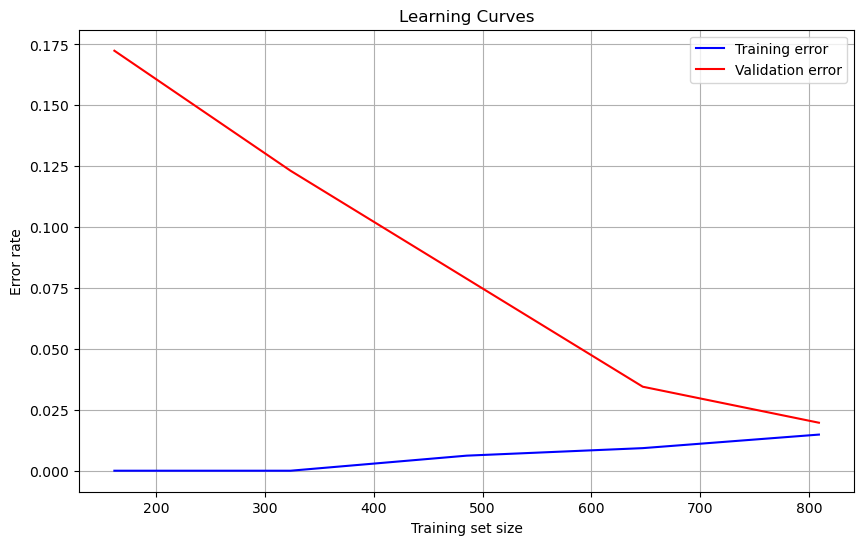

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def plot_learning_curves(X_train, y_train, X_val, y_val, 
                        n_estimators=100, max_depth=3, learning_rate=0.1):
    train_errors, val_errors = [], []
    m_range = np.linspace(0.2, 1.0, 5)  # Percentage of training data
    
    for m_pct in m_range:
        m = int(m_pct * len(X_train))
        
        # Train model on subset of training data (remove random_state)
        model = XGBoostClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate
        )
        model.fit(X_train[:m], y_train[:m])
        
        # Training error
        y_train_pred = model.predict(X_train[:m])
        train_errors.append(1 - accuracy_score(y_train[:m], y_train_pred))
        
        # Validation error
        y_val_pred = model.predict(X_val)
        val_errors.append(1 - accuracy_score(y_val, y_val_pred))
    
    plt.figure(figsize=(10, 6))
    plt.plot(m_range * len(X_train), train_errors, 'b-', label='Training error')
    plt.plot(m_range * len(X_train), val_errors, 'r-', label='Validation error')
    plt.xlabel('Training set size')
    plt.ylabel('Error rate')
    plt.title('Learning Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Plot learning curves
plot_learning_curves(X_train, y_train, X_val, y_val)

## Step10: Visualization on Evaluation Plotting


Training Set ROC Curve:


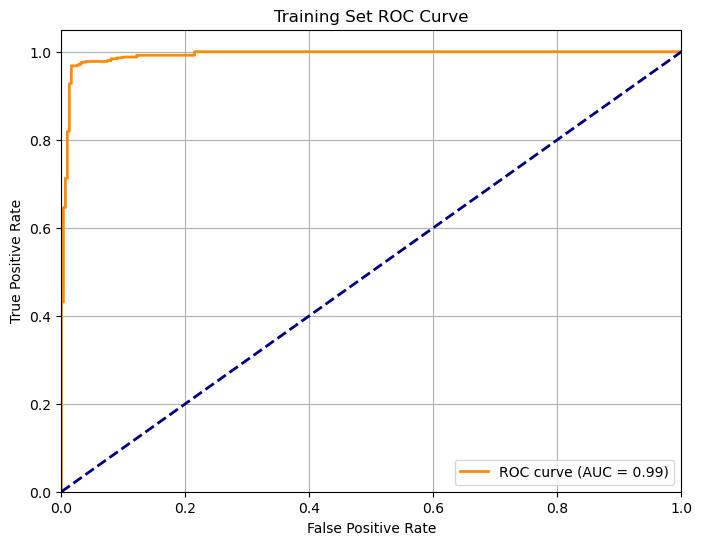


Test Set ROC Curve:


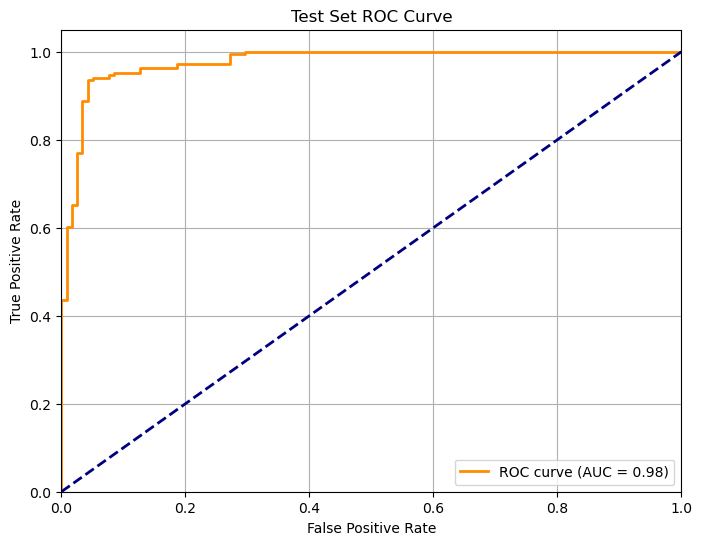


Training Set Precision-Recall Curve:


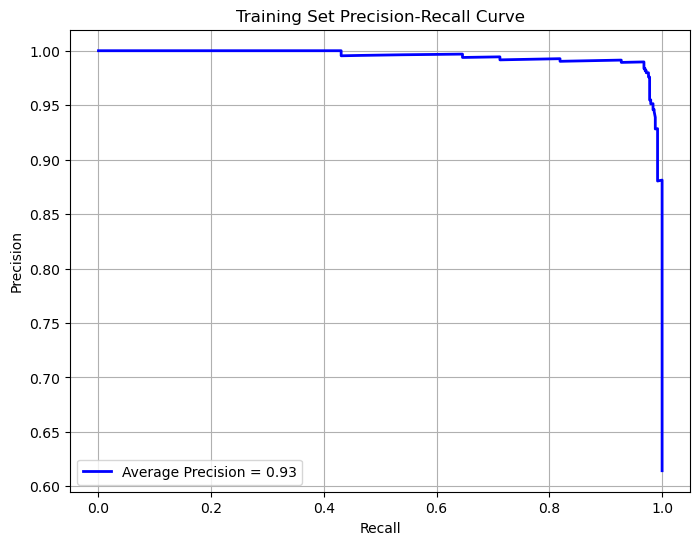


Test Set Precision-Recall Curve:


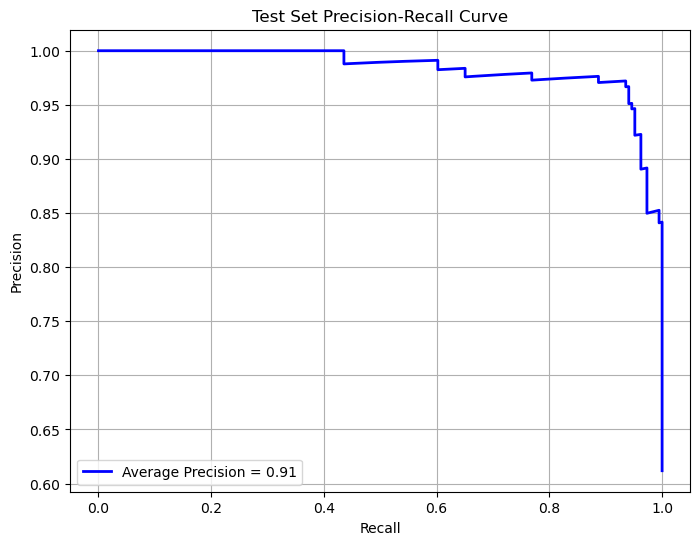


Training Set Confusion Matrix:


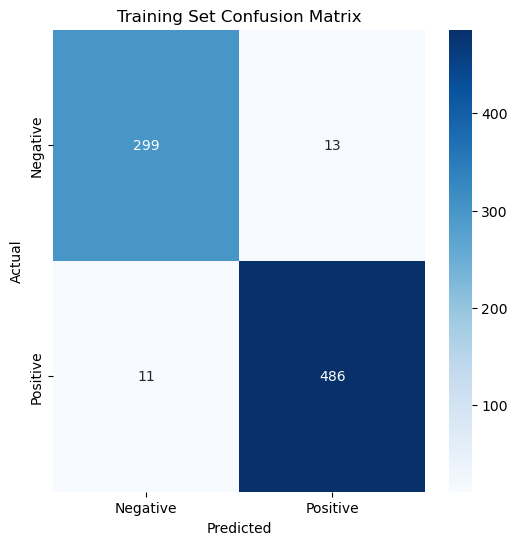


Test Set Confusion Matrix:


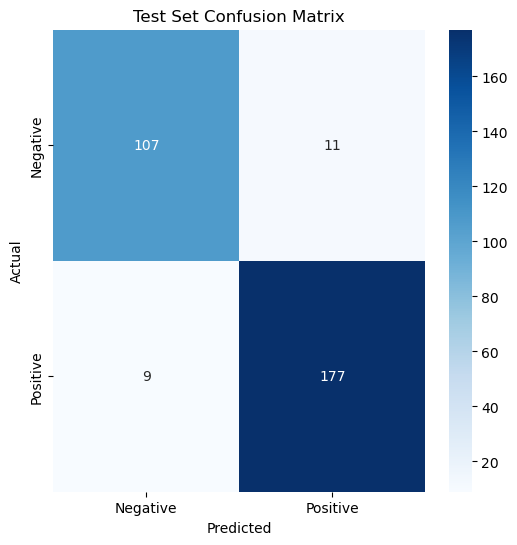


Training Set Probability Distribution:


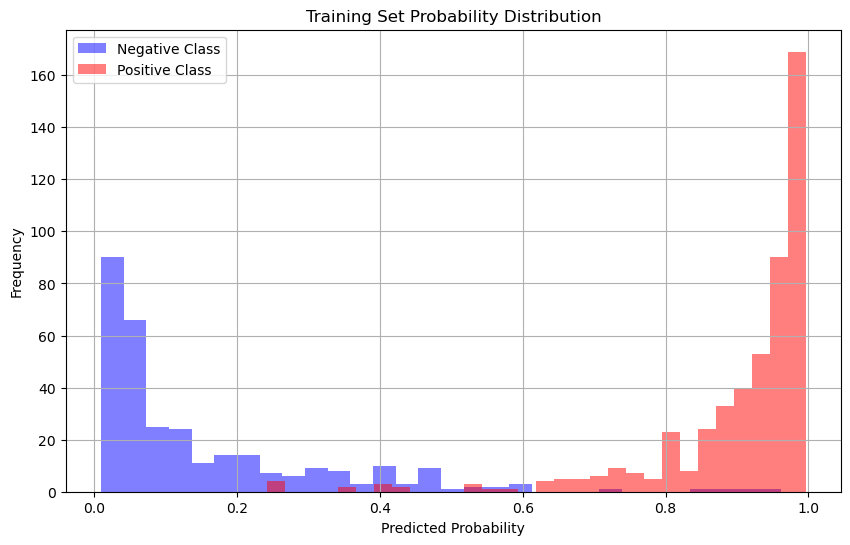


Test Set Probability Distribution:


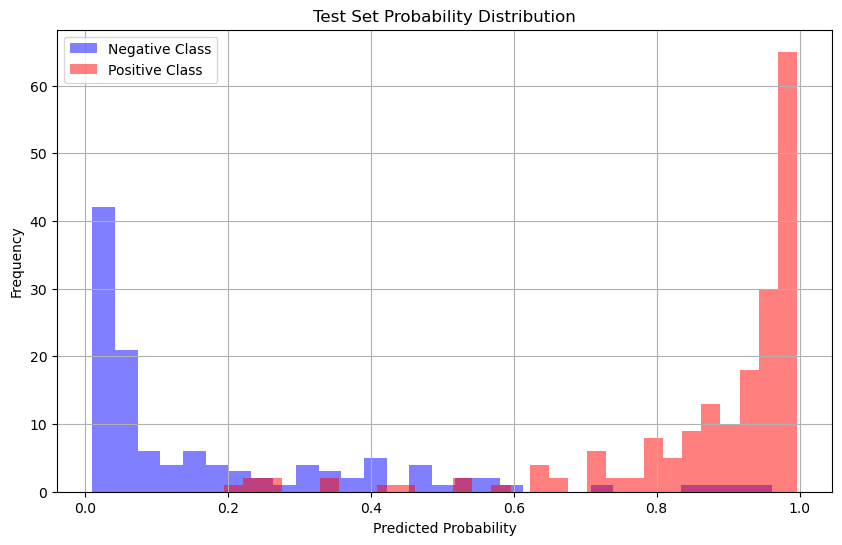


Threshold Analysis on Test Set:


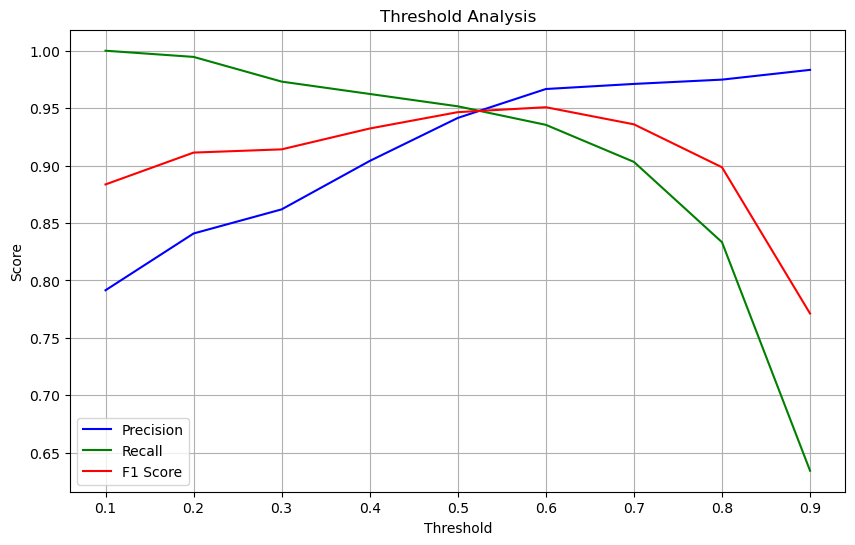


Cross-Validation Metrics Visualization:


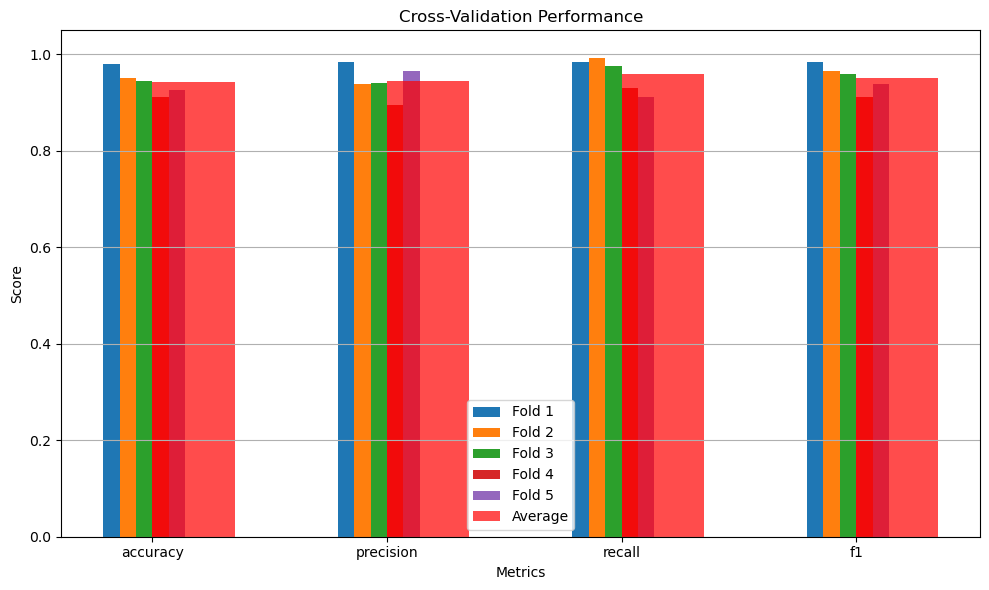

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

# 1. ROC Curve Visualization
def plot_roc_curves(y_true, y_scores, title='ROC Curve'):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
            label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    return roc_auc

# 2. Precision-Recall Curve Visualization
def plot_precision_recall_curves(y_true, y_scores, title='Precision-Recall Curve'):
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    average_precision = np.mean(precision)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, 
            label=f'Average Precision = {average_precision:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()
    return average_precision

# 3. Confusion Matrix Visualization
def plot_confusion_matrices(y_true, y_pred, classes=None, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    if classes is None:
        classes = ['Negative', 'Positive']
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# 4. Training Cost vs Iteration Plot
def plot_training_cost(cost_history, val_cost_history=None, title='Training Progress'):
    plt.figure(figsize=(10, 6))
    plt.plot(cost_history, label='Training Cost')
    if val_cost_history is not None:
        plt.plot(val_cost_history, label='Validation Cost')
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# 5. Probability Distribution Visualization
def plot_probability_distributions(y_true, y_scores, title='Predicted Probability Distribution'):
    plt.figure(figsize=(10, 6))
    plt.hist(y_scores[y_true == 0], bins=30, alpha=0.5, label='Negative Class', color='blue')
    plt.hist(y_scores[y_true == 1], bins=30, alpha=0.5, label='Positive Class', color='red')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# 6. Threshold Analysis Visualization
def plot_threshold_analysis(y_true, y_scores, thresholds=np.linspace(0.1, 0.9, 9)):
    precisions = []
    recalls = []
    f1_scores = []
    
    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)
        precisions.append(precision_score(y_true, y_pred, zero_division=0))
        recalls.append(recall_score(y_true, y_pred, zero_division=0))
        f1_scores.append(f1_score(y_true, y_pred, zero_division=0))
    
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions, 'b-', label='Precision')
    plt.plot(thresholds, recalls, 'g-', label='Recall')
    plt.plot(thresholds, f1_scores, 'r-', label='F1 Score')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Threshold Analysis')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    best_idx = np.argmax(f1_scores)
    return thresholds[best_idx]

# 7. Cross-Validation Metrics Visualization
def plot_cv_metrics(cv_metrics, fold_metrics, title='Cross-Validation Performance'):
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    avg_values = [cv_metrics[m] for m in metrics]
    fold_values = [[fold[m] for m in metrics] for fold in fold_metrics]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    plt.figure(figsize=(10, 6))
    for i, fold in enumerate(fold_values):
        plt.bar(x - width/2 + (i/len(fold_metrics))*width, fold, width/len(fold_metrics), 
                label=f'Fold {i+1}')
    
    plt.bar(x + width/2, avg_values, width, color='red', alpha=0.7, label='Average')
    
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title(title)
    plt.xticks(x, metrics)
    plt.legend()
    plt.grid(True, axis='y')
    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.show()

# Generate predictions and scores using your XGBoost model
y_train_scores = xgb.predict_proba(X_train)
y_test_scores = xgb.predict_proba(X_test)
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)

# 1. Plot ROC curves
print("\nTraining Set ROC Curve:")
train_auc = plot_roc_curves(y_train, y_train_scores, 'Training Set ROC Curve')
print("\nTest Set ROC Curve:")
test_auc = plot_roc_curves(y_test, y_test_scores, 'Test Set ROC Curve')

# 2. Plot Precision-Recall curves
print("\nTraining Set Precision-Recall Curve:")
train_ap = plot_precision_recall_curves(y_train, y_train_scores, 'Training Set Precision-Recall Curve')
print("\nTest Set Precision-Recall Curve:")
test_ap = plot_precision_recall_curves(y_test, y_test_scores, 'Test Set Precision-Recall Curve')

# 3. Plot Confusion matrices
print("\nTraining Set Confusion Matrix:")
plot_confusion_matrices(y_train, y_train_pred, title='Training Set Confusion Matrix')
print("\nTest Set Confusion Matrix:")
plot_confusion_matrices(y_test, y_test_pred, title='Test Set Confusion Matrix')

# 4. Plot Training cost (if available)
if hasattr(xgb, 'cost_history'):
    print("\nTraining Cost Progress:")
    plot_training_cost(xgb.cost_history, title='Training Cost')

# 5. Plot Probability distributions
print("\nTraining Set Probability Distribution:")
plot_probability_distributions(y_train, y_train_scores, 'Training Set Probability Distribution')
print("\nTest Set Probability Distribution:")
plot_probability_distributions(y_test, y_test_scores, 'Test Set Probability Distribution')

# 6. Threshold analysis
print("\nThreshold Analysis on Test Set:")
best_threshold = plot_threshold_analysis(y_test, y_test_scores)

# 7. Cross-validation results visualization (if performed)
if 'cv_metrics' in locals() and 'fold_metrics' in locals():
    print("\nCross-Validation Metrics Visualization:")
    plot_cv_metrics(cv_metrics, fold_metrics)

## Step11: Time & Memory Cost Record

In [16]:
_report()


[STATS] runtime = 793.30 s
[STATS] memory  = 202.75 → 30.95 MB (Δ -171.80 MB)
